# Stop loss and Take Profit

## Getting started 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("seaborn")
from itertools import product
import seaborn as sns

In [2]:
# Version 4.1 (Smoothing and Optimization)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    upsample:
        upsamples/copies trading positions back to higher frequency.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the parameter ranges.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, freq = 60, window = 1): 
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        freq: int
            data frequency/granularity to work with (in minutes)
        
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.freq = "{}min".format(freq) 
        self.window = window
                                
        self.prepare_data(freq, window) 
        self.upsample() 
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, freq, window): 
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.price.to_frame().copy()
        freq = "{}min".format(freq)
        resamp = data.resample(freq).last().dropna().iloc[:-1]
        resamp["returns"] = np.log(resamp / resamp.shift(1))
        resamp["roll_return"] = resamp["returns"].rolling(window).mean()
        resamp["position"] = -np.sign(resamp["roll_return"])
        resamp.dropna(inplace = True)
        self.results = resamp
        return resamp 
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
        
    def upsample(self):
        '''  Upsamples/copies trading positions back to higher frequency.
        '''
        
        data = self.data.copy()
        resamp = self.results.copy()
               
        data["position"] = resamp.position.shift()
        data = data.loc[resamp.index[0]:].copy()
        data.position = data.position.shift(-1).ffill()
        data.dropna(inplace=True)
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Freq = {} | Window = {} | TC = {}".format(self.symbol, self.freq, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, freq_range, window_range, metric = "Multiple"): # added: freq_range
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        freq_range: tuple
            tuples of the form (start, end, step size).
        
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        freqs = range(*freq_range)  # NEW!!!
        windows = range(*window_range)
        
        combinations = list(product(freqs, windows)) # NEW!!!
        
        performance = []
        for comb in combinations: # ADJ!!!
            self.prepare_data(comb[0], comb[1])
            self.upsample()
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["Freq", "Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the parameter ranges.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        freq = best.Freq.iloc[0] # NEW!!!
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Frequency: {} | Windows: {} | {}: {}".format(freq, window, self.metric, round(perf, 6))) # added: freq 
        self.test_strategy(freq, window) # added: freq
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else: # NEW!!!
            matrix = self.results_overview.pivot(index = "Freq", columns = "Windows", values = "Performance")
            
            plt.figure(figsize=(12,8))
            sns.set_theme(font_scale=1.5)
            sns.heatmap(matrix, cmap = "RdYlGn", robust = True, cbar_kws = {"label": "{}".format(self.metric)})
            plt.show()
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | Freq: {} | WINDOW = {}".format(self.symbol, self.freq, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

In [3]:
filepath = "one_minute.csv"
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
ptc = 0.00007

In [4]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start, end = end, tc = ptc)
tester

ConBacktester(symbol = EURUSD, start = 2018-01-01, end = 2019-12-31)

In [7]:
tester.test_strategy(201, 101)

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EURUSD | Freq: 201min | WINDOW = 101
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.412225
Multiple (Buy-and-Hold):     0.915552
--------------------------------------
Out-/Underperformance:       0.496673


CAGR:                        0.194307
Annualized Mean:             0.177955
Annualized Std:              0.06767
Sharpe Ratio:                2.629751
Sortino Ratio:               3.75337
Maximum Drawdown:            0.064834
Calmar Ratio:                2.99701
Max Drawdown Duration:       84 Days
Kelly Criterion:             39.36126


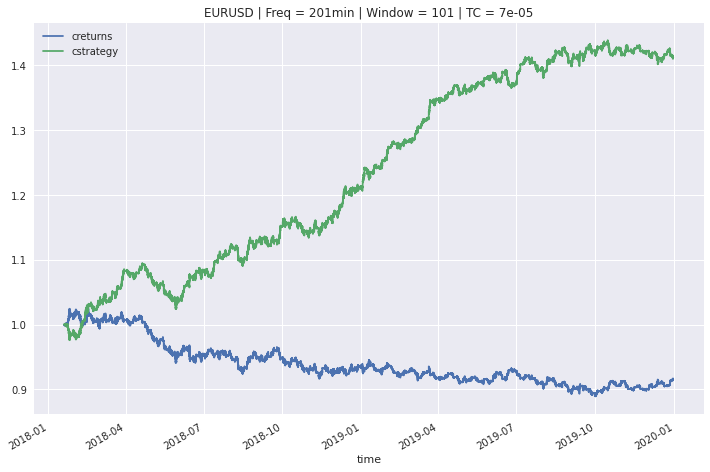

In [8]:
tester.plot_results()

In [9]:
data = tester.results.copy()
data

,price,returns,position,strategy,trades,creturns,cstrategy
time,,,,,,,
2018-01-19 16:53:00,1.22328,-0.000163,-1.0,NaN,0.0,0.999837,NaN
2018-01-19 16:54:00,1.22334,0.000049,-1.0,-0.000049,0.0,0.999886,0.999951
2018-01-19 16:55:00,1.22332,-0.000016,-1.0,0.000016,0.0,0.999869,0.999967
2018-01-19 16:56:00,1.22344,0.000098,-1.0,-0.000098,0.0,0.999967,0.999869
2018-01-19 16:57:00,1.22350,0.000049,-1.0,-0.000049,0.0,1.000016,0.999820
...,...,...,...,...,...,...,...
2019-12-30 23:56:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200
2019-12-30 23:57:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200
2019-12-30 23:58:00,1.12018,0.000000,-1.0,-0.000000,0.0,0.915569,1.412200


## Identify and label Trading Sessions

In [ ]:
data

__Trading Session: time period between two trades where traders just hold a position__.

In [ ]:
data.position.plot(figsize = (12, 8))
plt.show()

In [ ]:
data.trades.value_counts()

In [ ]:
data.loc[data.trades == 2] # rows with full trades

__-> in total 253 separate Trading Sessions__

In [ ]:
# number trading sessions consecutively from 0, 1, ..., 252 
np.sign(data.trades).cumsum().shift().fillna(0) 

In [ ]:
data["session"] = np.sign(data.trades).cumsum().shift().fillna(0)

In [ ]:
data.loc["2018-02-07 23:05:00" : "2018-02-07 23:15:00"] # zoom: first full trade

In [ ]:
data

## Cumulative/Compound Returns in a Trading Session

__Stop Loss__: Terminate/Close a Trading Position whenever the (cumulative/compound) session return hits a pre-defined loss level (e.g. -2%).

The loss-level is typically a simple return. Example: 2% Stop-Loss Price for a long position (buy price: 100) is 98.

In [ ]:
data

In [ ]:
data.strategy.cumsum() # cumulative log returns for the complete time period

In [ ]:
data.groupby("session").strategy.cumsum() # cumulative log returns per trading session

In [ ]:
data.groupby("session").strategy.cumsum().apply(np.exp) - 1  # compound simple returns per trading session

In [ ]:
data["session_compound"] = data.groupby("session").strategy.cumsum().apply(np.exp) - 1
data

In [ ]:
data.loc["2018-02-07 23:05:00" : "2018-02-07 23:15:00"] # first full trade in detail

In [ ]:
data["session_compound"].plot(figsize = (12, 8))
plt.show()

In [ ]:
session_returns = data.groupby("session").session_compound.last() # simple returns per trading session
session_returns

In [ ]:
session_returns.add(1).prod() # sanity check -> compounding session returns gives the strategy multiple

In [ ]:
session_returns.plot(figsize = (12, 8))
plt.show()

In [ ]:
session_returns.plot(kind = "hist", figsize = (12, 8), bins = 100)
plt.show()

## Adding Stop Loss

In [ ]:
data

In [ ]:
thresh = -0.02 # maximim loss: minus two percent (stop loss distance in %)

In [ ]:
data["session_compound"].plot(figsize = (12, 8)) # we´d expect three SL events
plt.show()

__Plan__: whenever the __compound return hits minus two percent__, close the trading postion and __go neutral__ (0)...

...and keep the neutral position __for the rest of the trading session__ (start trading again when the next trading session starts -> new signal)) 

Why? Stop Loss should __not increase trading activity/costs__.

In [ ]:
def stop_loss(group): # to be applied on all trading sessions
    if (group.session_compound <= thresh).any(): # check whether we hit the tresh in the session
        start = group[group.session_compound <= thresh].index[0] # get the bar of the first hit
        stop = group.index[-2] # second last bar of the session
        group.loc[start:stop, "position"] = 0 # change position to neutral from start until end
        return group
    else:
        return group # if we don´t hit the thresh, do nothing (return as it is)

In [ ]:
data.groupby("session").apply(stop_loss) # apply on all trading sessions

In [ ]:
data1 = data.groupby("session").apply(stop_loss)
data1

In [ ]:
data1.position.value_counts()

In [ ]:
data1.loc["2018-01-25 13:40:00":"2018-01-25 13:50:00"] # we hit the thresh in the first session

In [ ]:
data1.loc["2018-02-07 23:05:00" : "2018-02-07 23:15:00"] # we stay neutral until the end

__Update backtesting with updated Stop Loss positions__

In [ ]:
data1["strategy"] = data1.position.shift() * data1.returns
data1 

In [ ]:
data1["trades"] = data1.position.diff().fillna(0).abs()

In [ ]:
data1.strategy = data1.strategy - data1.trades * ptc

In [ ]:
data1["creturns"] = data1["returns"].cumsum().apply(np.exp)
data1["cstrategy"] = data1["strategy"].cumsum().apply(np.exp)

__Update Sessions (neutral sessions) and session compound returns__

In [ ]:
data1["session"] = np.sign(data1.trades).cumsum().shift().fillna(0)

In [ ]:
data1["session_compound"] = data1.groupby("session").strategy.cumsum().apply(np.exp) - 1

## How Stop Loss impacts the Trading Strategy

In [ ]:
data.session.max()

In [ ]:
data1.session.max() # three more (neutral) session

In [ ]:
data.position.value_counts()

In [ ]:
data1.position.value_counts() # neutral positions

In [ ]:
data.trades.value_counts()

In [ ]:
data1.trades.value_counts() # no increase in trading activity/costs

In [ ]:
data1.loc["2018-01-25 13:40:00":"2018-01-25 13:50:00"] # sanity check

In [ ]:
data1.cstrategy.plot(figsize = (12, 8), label = "Stop Loss @ -2.0%")
data.cstrategy.plot(label = "No Stop Loss")
plt.legend(fontsize = 15)
plt.show()

In [ ]:
data1 # reduction in multiple

In [ ]:
data["session_compound"].plot(figsize = (12, 8))
plt.show()

In [ ]:
data1["session_compound"].plot(figsize = (12, 8))
plt.show()

In [ ]:
session_returns1 = data1.groupby("session").session_compound.last()
session_returns1

In [ ]:
session_returns.plot(figsize = (12, 8))
plt.show()

In [ ]:
session_returns1.plot(figsize = (12, 8)) # limit losses (1x) vs. realize/fix losses when unfavorable (2x)
plt.show()

Lower Multiple caused by: limit losses (1x) vs. __realize/fix losses @ -2% when unfavorable (2x)__

## Updating the ConBacktester Class (Stop Loss)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
plt.style.use("seaborn")

In [ ]:
# Version 5.0 (Stop Loss)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    upsample:
        upsamples/copies trading positions back to higher frequency.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the parameter ranges.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    add_sessions:
        adds/labels trading sessions and their compound returns.
    
    add_stop_loss:
        adds stop loss to the strategy.
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, freq = 60, window = 1): 
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        freq: int
            data frequency/granularity to work with (in minutes)
        
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.freq = "{}min".format(freq) 
        self.window = window
                                
        self.prepare_data(freq, window) 
        self.upsample() 
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, freq, window): 
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.price.to_frame().copy()
        freq = "{}min".format(freq)
        resamp = data.resample(freq).last().dropna().iloc[:-1]
        resamp["returns"] = np.log(resamp / resamp.shift(1))
        resamp["roll_return"] = resamp["returns"].rolling(window).mean()
        resamp["position"] = -np.sign(resamp["roll_return"])
        resamp.dropna(inplace = True)
        self.results = resamp
        return resamp 
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
        
    def upsample(self):
        '''  Upsamples/copies trading positions back to higher frequency.
        '''
        
        data = self.data.copy()
        resamp = self.results.copy()
               
        data["position"] = resamp.position.shift()
        data = data.loc[resamp.index[0]:].copy()
        data.position = data.position.shift(-1).ffill()
        data.dropna(inplace=True)
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Freq = {} | Window = {} | TC = {}".format(self.symbol, self.freq, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, freq_range, window_range, metric = "Multiple"): 
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        freq_range: tuple
            tuples of the form (start, end, step size).
        
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        freqs = range(*freq_range)  
        windows = range(*window_range)
        
        combinations = list(product(freqs, windows)) 
        
        performance = []
        for comb in combinations: 
            self.prepare_data(comb[0], comb[1])
            self.upsample()
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["Freq", "Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the parameter ranges.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        freq = best.Freq.iloc[0] 
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Frequency: {} | Windows: {} | {}: {}".format(freq, window, self.metric, round(perf, 6))) 
        self.test_strategy(freq, window) 
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else: 
            matrix = self.results_overview.pivot(index = "Freq", columns = "Windows", values = "Performance")
            
            plt.figure(figsize=(12,8))
            sns.set_theme(font_scale=1.5)
            sns.heatmap(matrix, cmap = "RdYlGn", robust = True, cbar_kws = {"label": "{}".format(self.metric)})
            plt.show()
            
    def add_sessions(self, visualize = False): # NEW!!!
        ''' 
        Adds/Labels Trading Sessions and their compound returns.
        
        Parameter
        ============
        visualize: bool, default False
            if True, visualize compound session returns over time
        '''
        
        if self.results is None:
            print("Run test_strategy() first.")
            
        data = self.results.copy()
        data["session"] = np.sign(data.trades).cumsum().shift().fillna(0)
        data["session_compound"] = data.groupby("session").strategy.cumsum().apply(np.exp) - 1
        self.results = data
        if visualize:
            data["session_compound"].plot(figsize = (12, 8))
            plt.show()
    
    def add_stop_loss(self, sl_thresh, report = True): # NEW!!!
        ''' 
        Adds Stop Loss to the Strategy.
        
        Parameter
        ============
        sl_thresh: float (negative)
            maximum loss level in % (e.g. -0.02 for -2%)
        
        report: bool, default True
            if True, print Performance Report incl. Stop Loss. 
        '''
        
        self.sl_thresh = sl_thresh
        
        if self.results is None:
            print("Run test_strategy() first.")
        
        self.add_sessions()
        self.results = self.results.groupby("session").apply(self.define_sl_pos)
        self.run_backtest()
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions()
        
        if report:
            self.print_performance()
        
    def define_sl_pos(self, group): # NEW!!!
        if (group.session_compound <= self.sl_thresh).any():
            start = group[group.session_compound <= self.sl_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, "position"] = 0
            return group
        else:
            return group 
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | Freq: {} | WINDOW = {}".format(self.symbol, self.freq, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

In [ ]:
filepath = "one_minute.csv"
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
ptc = 0.00007

In [ ]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start, end = end, tc = ptc)

In [ ]:
tester.test_strategy(201, 101)

In [ ]:
tester.results

In [ ]:
tester.add_sessions() 

In [ ]:
tester.results

In [ ]:
tester.add_sessions(visualize = True)

In [ ]:
tester.add_stop_loss(sl_thresh = -0.02, report = True)

In [ ]:
tester.plot_results()

In [ ]:
tester.add_stop_loss(sl_thresh = -0.001, report = True) # start with large SL distance and reduce (doesn´t work the other way)

## Adding Take Profit

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
plt.style.use("seaborn")

In [ ]:
# Version 5.1 (Stop Loss & Take Profit)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    upsample:
        upsamples/copies trading positions back to higher frequency.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the parameter ranges.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    add_sessions:
        adds/labels trading sessions and their compound returns.
    
    add_stop_loss:
        adds stop loss to the strategy.
    
    add_take_profit: 
        adds take profit to the strategy.
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, freq = 60, window = 1): 
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        freq: int
            data frequency/granularity to work with (in minutes)
        
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.freq = "{}min".format(freq) 
        self.window = window
                                
        self.prepare_data(freq, window) 
        self.upsample() 
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, freq, window): 
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.price.to_frame().copy()
        freq = "{}min".format(freq)
        resamp = data.resample(freq).last().dropna().iloc[:-1]
        resamp["returns"] = np.log(resamp / resamp.shift(1))
        resamp["roll_return"] = resamp["returns"].rolling(window).mean()
        resamp["position"] = -np.sign(resamp["roll_return"])
        resamp.dropna(inplace = True)
        self.results = resamp
        return resamp 
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
        
    def upsample(self):
        '''  Upsamples/copies trading positions back to higher frequency.
        '''
        
        data = self.data.copy()
        resamp = self.results.copy()
               
        data["position"] = resamp.position.shift()
        data = data.loc[resamp.index[0]:].copy()
        data.position = data.position.shift(-1).ffill()
        data.dropna(inplace=True)
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Freq = {} | Window = {} | TC = {}".format(self.symbol, self.freq, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, freq_range, window_range, metric = "Multiple"): 
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        freq_range: tuple
            tuples of the form (start, end, step size).
        
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        freqs = range(*freq_range)  
        windows = range(*window_range)
        
        combinations = list(product(freqs, windows)) 
        
        performance = []
        for comb in combinations: 
            self.prepare_data(comb[0], comb[1])
            self.upsample()
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["Freq", "Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the parameter ranges.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        freq = best.Freq.iloc[0] 
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Frequency: {} | Windows: {} | {}: {}".format(freq, window, self.metric, round(perf, 6))) 
        self.test_strategy(freq, window) 
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else: 
            matrix = self.results_overview.pivot(index = "Freq", columns = "Windows", values = "Performance")
            
            plt.figure(figsize=(12,8))
            sns.set_theme(font_scale=1.5)
            sns.heatmap(matrix, cmap = "RdYlGn", robust = True, cbar_kws = {"label": "{}".format(self.metric)})
            plt.show()
            
    def add_sessions(self, visualize = False):
        ''' 
        Adds/Labels Trading Sessions and their compound returns.
        
        Parameter
        ============
        visualize: bool, default False
            if True, visualize compound session returns over time
        '''
        
        if self.results is None:
            print("Run test_strategy() first.")
            
        data = self.results.copy()
        data["session"] = np.sign(data.trades).cumsum().shift().fillna(0)
        data["session_compound"] = data.groupby("session").strategy.cumsum().apply(np.exp) - 1
        self.results = data
        if visualize:
            data["session_compound"].plot(figsize = (12, 8))
            plt.show()
    
    def add_stop_loss(self, sl_thresh, report = True): 
        ''' 
        Adds Stop Loss to the Strategy.
        
        Parameter
        ============
        sl_thresh: float (negative)
            maximum loss level in % (e.g. -0.02 for -2%)
        
        report: bool, default True
            if True, print Performance Report incl. Stop Loss. 
        '''
        
        self.sl_thresh = sl_thresh
        
        if self.results is None:
            print("Run test_strategy() first.")
        
        self.add_sessions()
        self.results = self.results.groupby("session").apply(self.define_sl_pos)
        self.run_backtest()
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions()
        
        if report:
            self.print_performance()
            
            
    def add_take_profit(self, tp_thresh, report = True): # NEW!!!
        ''' 
        Adds Take Profit to the Strategy.
        
        Parameter
        ============
        tp_thresh: float (positive)
            maximum profit level in % (e.g. 0.02 for 2%)
        
        report: bool, default True
            if True, print Performance Report incl. Take Profit. 
        '''
        self.tp_thresh = tp_thresh
        
        if self.results is None:
            print("Run test_strategy() first.")
        
        self.add_sessions()
        self.results = self.results.groupby("session").apply(self.define_tp_pos)
        self.run_backtest()
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions()
        
        if report:
            self.print_performance()
        
    def define_sl_pos(self, group):
        if (group.session_compound <= self.sl_thresh).any():
            start = group[group.session_compound <= self.sl_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, "position"] = 0
            return group
        else:
            return group 
        
    def define_tp_pos(self, group): # NEW!!!
        if (group.session_compound >= self.tp_thresh).any():
            start = group[group.session_compound >= self.tp_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, "position"] = 0
            return group
        else:
            return group
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | Freq: {} | WINDOW = {}".format(self.symbol, self.freq, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

In [ ]:
filepath = "one_minute.csv"
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
ptc = 0.00007

In [ ]:
tester = ConBacktester(filepath = filepath, symbol = symbol, start = start, end = end, tc = ptc)

In [ ]:
tester.test_strategy(201, 101)

In [ ]:
tester.results

In [ ]:
tester.add_sessions(visualize = True)

In [ ]:
tester.add_take_profit(tp_thresh = 0.01, report = True)

In [ ]:
tester.plot_results()

In [ ]:
tester.add_sessions(visualize = True)

In [ ]:
tester.add_take_profit(tp_thresh = 0.001, report = True) # start with large TP distance and reduce (doesn´t work the other way)

__Combining Stop Loss and Take Profit__

In [ ]:
tester.test_strategy(201, 101)

In [ ]:
tester.add_stop_loss(sl_thresh = -0.005)

In [ ]:
tester.add_take_profit(tp_thresh = 0.005)

In [ ]:
tester.plot_results()

## Stop Loss & Take Profit - an deeper analysis

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
plt.style.use("seaborn")

In [ ]:
filepath = "one_minute.csv"
symbol = "EURUSD"
start = "2018-01-01"
end = "2019-12-31"
ptc = 0.00007

__1. Profitable Underlying Strategy (Simple Contrarian for EURUSD)__

In [ ]:
# Version 5.1 (Stop Loss & Take Profit)

class ConBacktester():
    ''' Class for the vectorized backtesting of simple contrarian trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    upsample:
        upsamples/copies trading positions back to higher frequency.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the parameter ranges.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    add_sessions:
        adds/labels trading sessions and their compound returns.
    
    add_stop_loss:
        adds stop loss to the strategy.
    
    add_take_profit: 
        adds take profit to the strategy.
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, freq = 60, window = 1): 
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        freq: int
            data frequency/granularity to work with (in minutes)
        
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.freq = "{}min".format(freq) 
        self.window = window
                                
        self.prepare_data(freq, window) 
        self.upsample() 
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, freq, window): 
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.price.to_frame().copy()
        freq = "{}min".format(freq)
        resamp = data.resample(freq).last().dropna().iloc[:-1]
        resamp["returns"] = np.log(resamp / resamp.shift(1))
        resamp["roll_return"] = resamp["returns"].rolling(window).mean()
        resamp["position"] = -np.sign(resamp["roll_return"])
        resamp.dropna(inplace = True)
        self.results = resamp
        return resamp 
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
        
    def upsample(self):
        '''  Upsamples/copies trading positions back to higher frequency.
        '''
        
        data = self.data.copy()
        resamp = self.results.copy()
               
        data["position"] = resamp.position.shift()
        data = data.loc[resamp.index[0]:].copy()
        data.position = data.position.shift(-1).ffill()
        data.dropna(inplace=True)
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Freq = {} | Window = {} | TC = {}".format(self.symbol, self.freq, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, freq_range, window_range, metric = "Multiple"): 
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        freq_range: tuple
            tuples of the form (start, end, step size).
        
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        freqs = range(*freq_range)  
        windows = range(*window_range)
        
        combinations = list(product(freqs, windows)) 
        
        performance = []
        for comb in combinations: 
            self.prepare_data(comb[0], comb[1])
            self.upsample()
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["Freq", "Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the parameter ranges.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        freq = best.Freq.iloc[0] 
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Frequency: {} | Windows: {} | {}: {}".format(freq, window, self.metric, round(perf, 6))) 
        self.test_strategy(freq, window) 
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else: 
            matrix = self.results_overview.pivot(index = "Freq", columns = "Windows", values = "Performance")
            
            plt.figure(figsize=(12,8))
            sns.set_theme(font_scale=1.5)
            sns.heatmap(matrix, cmap = "RdYlGn", robust = True, cbar_kws = {"label": "{}".format(self.metric)})
            plt.show()
            
    def add_sessions(self, visualize = False):
        ''' 
        Adds/Labels Trading Sessions and their compound returns.
        
        Parameter
        ============
        visualize: bool, default False
            if True, visualize compound session returns over time
        '''
        
        if self.results is None:
            print("Run test_strategy() first.")
            
        data = self.results.copy()
        data["session"] = np.sign(data.trades).cumsum().shift().fillna(0)
        data["session_compound"] = data.groupby("session").strategy.cumsum().apply(np.exp) - 1
        self.results = data
        if visualize:
            data["session_compound"].plot(figsize = (12, 8))
            plt.show()
    
    def add_stop_loss(self, sl_thresh, report = True): 
        ''' 
        Adds Stop Loss to the Strategy.
        
        Parameter
        ============
        sl_thresh: float (negative)
            maximum loss level in % (e.g. -0.02 for -2%)
        
        report: bool, default True
            if True, print Performance Report incl. Stop Loss. 
        '''
        
        self.sl_thresh = sl_thresh
        
        if self.results is None:
            print("Run test_strategy() first.")
        
        self.add_sessions()
        self.results = self.results.groupby("session").apply(self.define_sl_pos)
        self.run_backtest()
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions()
        
        if report:
            self.print_performance()
            
            
    def add_take_profit(self, tp_thresh, report = True):
        ''' 
        Adds Take Profit to the Strategy.
        
        Parameter
        ============
        tp_thresh: float (positive)
            maximum profit level in % (e.g. 0.02 for 2%)
        
        report: bool, default True
            if True, print Performance Report incl. Take Profit. 
        '''
        self.tp_thresh = tp_thresh
        
        if self.results is None:
            print("Run test_strategy() first.")
        
        self.add_sessions()
        self.results = self.results.groupby("session").apply(self.define_tp_pos)
        self.run_backtest()
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions()
        
        if report:
            self.print_performance()
        
    def define_sl_pos(self, group):
        if (group.session_compound <= self.sl_thresh).any():
            start = group[group.session_compound <= self.sl_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, "position"] = 0
            return group
        else:
            return group 
        
    def define_tp_pos(self, group):
        if (group.session_compound >= self.tp_thresh).any():
            start = group[group.session_compound >= self.tp_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, "position"] = 0
            return group
        else:
            return group
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | Freq: {} | WINDOW = {}".format(self.symbol, self.freq, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

In [ ]:
contester = ConBacktester(filepath = filepath, symbol = symbol, start = start, end = end, tc = ptc)
contester.test_strategy(201, 101)

In [ ]:
contester.plot_results()

__2. Unprofitable Underlying Strategy (Simple Momentum for EURUSD)__

In [ ]:
class MomBacktester():
    ''' Class for the vectorized backtesting of simple momentum trading strategies.
    
    Attributes
    ============
    filepath: str
        local filepath of the dataset (csv-file)
    symbol: str
        ticker symbol (instrument) to be backtested
    start: str
        start date for data import
    end: str
        end date for data import
    tc: float
        proportional trading costs per trade
    
    
    Methods
    =======
    get_data:
        imports the data.
        
    test_strategy:
        prepares the data and backtests the trading strategy incl. reporting (wrapper).
        
    prepare_data:
        prepares the data for backtesting.
    
    run_backtest:
        runs the strategy backtest.
        
    upsample:
        upsamples/copies trading positions back to higher frequency.
        
    plot_results:
        plots the cumulative performance of the trading strategy compared to buy-and-hold.
        
    optimize_strategy:
        backtests strategy for different parameter values incl. optimization and reporting (wrapper).
    
    find_best_strategy:
        finds the optimal strategy (global maximum) given the parameter ranges.
        
    visualize_many:
        plots parameter values vs. performance. 
        
    add_sessions:
        adds/labels trading sessions and their compound returns.
    
    add_stop_loss:
        adds stop loss to the strategy.
    
    add_take_profit: 
        adds take profit to the strategy.
        
    print_performance:
        calculates and prints various performance metrics.
        
    '''    
    
    def __init__(self, filepath, symbol, start, end, tc):
        
        self.filepath = filepath
        self.symbol = symbol
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None
        self.get_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
        
    def __repr__(self):
        return "ConBacktester(symbol = {}, start = {}, end = {})".format(self.symbol, self.start, self.end)
        
    def get_data(self):
        ''' Imports the data.
        '''
        raw = pd.read_csv(self.filepath, parse_dates = ["time"], index_col = "time")
        raw = raw[self.symbol].to_frame().fillna(method = "ffill")
        raw = raw.loc[self.start:self.end].copy()
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw.price / raw.price.shift(1))
        self.data = raw
        
    def test_strategy(self, freq = 60, window = 1): 
        '''
        Prepares the data and backtests the trading strategy incl. reporting (Wrapper).
         
        Parameters
        ============
        freq: int
            data frequency/granularity to work with (in minutes)
        
        window: int
            time window (number of bars) to be considered for the strategy.
        '''
        self.freq = "{}min".format(freq) 
        self.window = window
                                
        self.prepare_data(freq, window) 
        self.upsample() 
        self.run_backtest()
        
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        self.print_performance()
    
    def prepare_data(self, freq, window): 
        ''' Prepares the Data for Backtesting.
        '''
        data = self.data.price.to_frame().copy()
        freq = "{}min".format(freq)
        resamp = data.resample(freq).last().dropna().iloc[:-1]
        resamp["returns"] = np.log(resamp / resamp.shift(1))
        resamp["roll_return"] = resamp["returns"].rolling(window).mean()
        resamp["position"] = +np.sign(resamp["roll_return"])
        resamp.dropna(inplace = True)
        self.results = resamp
        return resamp 
    
    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        
        data = self.results.copy()
        data["strategy"] = data["position"].shift(1) * data["returns"]
        
        # determine the number of trades in each bar
        data["trades"] = data.position.diff().fillna(0).abs()
        
        # subtract transaction/trading costs from pre-cost return
        data.strategy = data.strategy - data.trades * self.tc
        
        self.results = data
        
    def upsample(self):
        '''  Upsamples/copies trading positions back to higher frequency.
        '''
        
        data = self.data.copy()
        resamp = self.results.copy()
               
        data["position"] = resamp.position.shift()
        data = data.loc[resamp.index[0]:].copy()
        data.position = data.position.shift(-1).ffill()
        data.dropna(inplace=True)
        self.results = data
    
    def plot_results(self):
        '''  Plots the cumulative performance of the trading strategy compared to buy-and-hold.
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | Freq = {} | Window = {} | TC = {}".format(self.symbol, self.freq, self.window, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
            
    def optimize_strategy(self, freq_range, window_range, metric = "Multiple"): 
        '''
        Backtests strategy for different parameter values incl. Optimization and Reporting (Wrapper).
         
        Parameters
        ============
        freq_range: tuple
            tuples of the form (start, end, step size).
        
        window_range: tuple
            tuples of the form (start, end, step size).
        
        metric: str
            performance metric to be optimized (can be: "Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")
        '''
        
        self.metric = metric
        
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar": 
            performance_function = self.calculate_calmar
        elif metric == "Kelly": 
            performance_function = self.calculate_kelly_criterion
        
        freqs = range(*freq_range)  
        windows = range(*window_range)
        
        combinations = list(product(freqs, windows)) 
        
        performance = []
        for comb in combinations: 
            self.prepare_data(comb[0], comb[1])
            self.upsample()
            self.run_backtest()
            performance.append(performance_function(self.results.strategy))
    
        self.results_overview =  pd.DataFrame(data = np.array(combinations), columns = ["Freq", "Windows"])
        self.results_overview["Performance"] = performance
        self.find_best_strategy()
        
    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the parameter ranges.
        '''
        best = self.results_overview.nlargest(1, "Performance")
        freq = best.Freq.iloc[0] 
        window = best.Windows.iloc[0]
        perf = best.Performance.iloc[0]
        print("Frequency: {} | Windows: {} | {}: {}".format(freq, window, self.metric, round(perf, 6))) 
        self.test_strategy(freq, window) 
        
    def visualize_many(self):
        ''' Plots parameter values vs. Performance.
        '''

        if self.results_overview is None:
            print("Run optimize_strategy() first.")
        else: 
            matrix = self.results_overview.pivot(index = "Freq", columns = "Windows", values = "Performance")
            
            plt.figure(figsize=(12,8))
            sns.set_theme(font_scale=1.5)
            sns.heatmap(matrix, cmap = "RdYlGn", robust = True, cbar_kws = {"label": "{}".format(self.metric)})
            plt.show()
            
    def add_sessions(self, visualize = False):
        ''' 
        Adds/Labels Trading Sessions and their compound returns.
        
        Parameter
        ============
        visualize: bool, default False
            if True, visualize compound session returns over time
        '''
        
        if self.results is None:
            print("Run test_strategy() first.")
            
        data = self.results.copy()
        data["session"] = np.sign(data.trades).cumsum().shift().fillna(0)
        data["session_compound"] = data.groupby("session").strategy.cumsum().apply(np.exp) - 1
        self.results = data
        if visualize:
            data["session_compound"].plot(figsize = (12, 8))
            plt.show()
    
    def add_stop_loss(self, sl_thresh, report = True): 
        ''' 
        Adds Stop Loss to the Strategy.
        
        Parameter
        ============
        sl_thresh: float (negative)
            maximum loss level in % (e.g. -0.02 for -2%)
        
        report: bool, default True
            if True, print Performance Report incl. Stop Loss. 
        '''
        
        self.sl_thresh = sl_thresh
        
        if self.results is None:
            print("Run test_strategy() first.")
        
        self.add_sessions()
        self.results = self.results.groupby("session").apply(self.define_sl_pos)
        self.run_backtest()
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions()
        
        if report:
            self.print_performance()
            
            
    def add_take_profit(self, tp_thresh, report = True):
        ''' 
        Adds Take Profit to the Strategy.
        
        Parameter
        ============
        tp_thresh: float (positive)
            maximum profit level in % (e.g. 0.02 for 2%)
        
        report: bool, default True
            if True, print Performance Report incl. Take Profit. 
        '''
        self.tp_thresh = tp_thresh
        
        if self.results is None:
            print("Run test_strategy() first.")
        
        self.add_sessions()
        self.results = self.results.groupby("session").apply(self.define_tp_pos)
        self.run_backtest()
        data = self.results.copy()
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        self.add_sessions()
        
        if report:
            self.print_performance()
        
    def define_sl_pos(self, group):
        if (group.session_compound <= self.sl_thresh).any():
            start = group[group.session_compound <= self.sl_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, "position"] = 0
            return group
        else:
            return group 
        
    def define_tp_pos(self, group): 
        if (group.session_compound >= self.tp_thresh).any():
            start = group[group.session_compound >= self.tp_thresh].index[0]
            stop = group.index[-2]
            group.loc[start:stop, "position"] = 0
            return group
        else:
            return group
            
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | Freq: {} | WINDOW = {}".format(self.symbol, self.freq, self.window))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    
    ############################## Performance ######################################

In [ ]:
momtester = MomBacktester(filepath = filepath, symbol = symbol, start = start, end = end, tc = ptc)
momtester.test_strategy(201, 101)

In [ ]:
momtester.plot_results()

__1.a Profitable Strategy & Stop Loss__

In [ ]:
contester.add_sessions(True)

In [ ]:
thresholds = np.arange(-0.065, 0, 0.0005)
thresholds

In [ ]:
multiples = []
sharpes = []
calmars = []
for thresh in thresholds:
    contester.test_strategy(201, 101)
    contester.add_stop_loss(thresh, report = False)
    multiples.append(contester.calculate_multiple(contester.results.strategy))
    sharpes.append(contester.calculate_sharpe(contester.results.strategy))
    calmars.append(contester.calculate_calmar(contester.results.strategy))

In [ ]:
df = pd.DataFrame(data = {"Multiple":multiples, "Sharpe":sharpes, "Calmar":calmars}, index = thresholds)
df.index.name = "Stop Loss"

In [ ]:
df

In [ ]:
df.plot(figsize = (12, 8), subplots = True, fontsize = 15)
plt.xlabel("Stop Loss", fontsize = 15)
plt.show()

__1.b Profitable Strategy & Take Profit__

In [ ]:
contester.test_strategy(201, 101)

In [ ]:
thresholds = np.arange(0.02, 0, -0.0002)
thresholds

In [ ]:
multiples = []
sharpes = []
calmars = []
for thresh in thresholds:
    contester.test_strategy(201, 101)
    contester.add_take_profit(thresh, report = False)
    multiples.append(contester.calculate_multiple(contester.results.strategy))
    sharpes.append(contester.calculate_sharpe(contester.results.strategy))
    calmars.append(contester.calculate_calmar(contester.results.strategy))

In [ ]:
df = pd.DataFrame(data = {"Multiple":multiples, "Sharpe":sharpes, "Calmar":calmars}, index = thresholds)
df.index.name = "Take Profit"

In [ ]:
df.plot(figsize = (12, 8), subplots = True, fontsize = 15)
plt.xlabel("Take Profit", fontsize = 15)
plt.show()

__2.a Unprofitable Strategy and Stop Loss__

In [ ]:
momtester.add_sessions(True)

In [ ]:
thresholds = np.arange(-0.02, 0, 0.0002)
thresholds

In [ ]:
multiples = []
sharpes = []
calmars = []
for thresh in thresholds:
    momtester.test_strategy(201, 101)
    momtester.add_stop_loss(thresh, report = False)
    multiples.append(momtester.calculate_multiple(momtester.results.strategy))
    sharpes.append(momtester.calculate_sharpe(momtester.results.strategy))
    calmars.append(momtester.calculate_calmar(momtester.results.strategy))

In [ ]:
df = pd.DataFrame(data = {"Multiple":multiples, "Sharpe":sharpes, "Calmar":calmars}, index = thresholds)
df.index.name = "Stop Loss"

In [ ]:
df.plot(figsize = (12, 8), subplots = True, fontsize = 15)
plt.xlabel("Stop Loss", fontsize = 15)
plt.show()

__2.b Unprofitable Strategy and Take Profit__

In [ ]:
momtester.test_strategy(201, 101)

In [ ]:
momtester.add_sessions(True)

In [ ]:
thresholds = np.arange(0.065, 0, -0.0005)
thresholds

In [ ]:
multiples = []
sharpes = []
calmars = []
for thresh in thresholds:
    momtester.test_strategy(201, 101)
    momtester.add_take_profit(thresh, report = False)
    multiples.append(momtester.calculate_multiple(momtester.results.strategy))
    sharpes.append(momtester.calculate_sharpe(momtester.results.strategy))
    calmars.append(momtester.calculate_calmar(momtester.results.strategy))

In [ ]:
df = pd.DataFrame(data = {"Multiple":multiples, "Sharpe":sharpes, "Calmar":calmars}, index = thresholds)
df.index.name = "Take Profit"

In [ ]:
df.plot(figsize = (12, 8), subplots = True, fontsize = 15)
plt.xlabel("Take Profit", fontsize = 15)
plt.show()